In [95]:
import pandas as pd
import os
import re
import seaborn as sns
from datetime import timedelta
import numpy as np
from tqdm import tqdm_notebook

# Load Data

In [182]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Raw'
tslim_1 = pd.read_csv(f'{BASE_PATH}/tslim_therapy_data_2-18-23_5-18-23.csv')
tslim_2 = pd.read_csv(f'{BASE_PATH}/tslim_therapy_data_5-18-23_8-18-23.csv')
bg_1 = pd.read_csv(f'{BASE_PATH}/bg_data_2-18-23_5-18-23.csv')
bg_2 = pd.read_csv(f'{BASE_PATH}/bg_data_5-18-23_8-18-23.csv')
hr = pd.read_csv(f'{BASE_PATH}/heart_rate_data_12-12-20_8-18-23.csv')
workout = pd.read_csv(f'{BASE_PATH}/workout_data_12-12-20_8-18-23.csv')
basal_energy = pd.read_csv(f'{BASE_PATH}/basal_energy_burned_data_12-12-20_8-18-23.csv')
active_energy = pd.read_csv(f'{BASE_PATH}/active_energy_burned_data_12-12-20_8-18-23.csv')

<ipython-input-182-47bd0cef1a0b>:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  hr = pd.read_csv(f'{BASE_PATH}/heart_rate_data_12-12-20_8-18-23.csv')
<ipython-input-182-47bd0cef1a0b>:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  basal_energy = pd.read_csv(f'{BASE_PATH}/basal_energy_burned_data_12-12-20_8-18-23.csv')
<ipython-input-182-47bd0cef1a0b>:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  active_energy = pd.read_csv(f'{BASE_PATH}/active_energy_burned_data_12-12-20_8-18-23.csv')


# Process & Merge

In [45]:
def process_tslim(df):
    df = df.reset_index()
    df.columns = list(df.columns[2:]) + ['', '']
    df = df[['CompletionDateTime', 'Description', 'BG', 'InsulinDelivered']]
    df['CompletionDateTime'] = pd.to_datetime(df['CompletionDateTime'])
    df = df.rename(columns={'CompletionDateTime': 'Time'})
    return df

def process_bg(df):
    df = df.reset_index()
    df.columns = list(df.columns[1:]) + ['']
    df = df[['EventDateTime', 'Readings (CGM / BGM)']]
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.rename(columns={'EventDateTime': 'Time', 'Readings (CGM / BGM)': 'BG'})
    return df

def process_body_metrics(df, metric):
    df = df.rename(columns={'sourceVersion': 'Time', 'unit': metric})[['Time', metric]].reset_index(drop=True)
    df['Time'] = pd.to_datetime(df['Time'])   
    return df

def process_workout(df):
    df = df[['startDate', 'endDate', 'workoutActivityType']]
    df['workoutActivityType'] = df['workoutActivityType'].str[len('HKWorkoutActivityType'):]
    df['workoutActivityType'] = df['workoutActivityType'].map(lambda x: ' '.join(re.split('(?<=.)(?=[A-Z])', x)))
    df = df.rename(columns={'startDate': 'StartTime', 'endDate': 'EndTime', 'workoutActivityType': 'WorkoutName'})
    return df


In [183]:
bg_1 = process_bg(bg_1)
bg_2 = process_bg(bg_2)

tslim_1 = process_tslim(tslim_1)
tslim_2 = process_tslim(tslim_2)

hr = process_body_metrics(hr, 'HR')
hr['Time'] = hr['Time'].dt.tz_localize(None) # remove timezone
basal_energy = process_body_metrics(basal_energy, 'BE')
active_energy = process_body_metrics(active_energy, 'AE')

workout = process_workout(workout)

<ipython-input-45-abd72a23a6ed>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['workoutActivityType'] = df['workoutActivityType'].str[len('HKWorkoutActivityType'):]
<ipython-input-45-abd72a23a6ed>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['workoutActivityType'] = df['workoutActivityType'].map(lambda x: ' '.join(re.split('(?<=.)(?=[A-Z])', x)))


Let's merge HR, insulin therapy, and BG data.

In [226]:
bg = pd.concat([bg_1, bg_2]).sort_values('Time')
tslim = pd.concat([tslim_1, tslim_2]).sort_values('Time')

hr = hr[hr['Time'] > tslim['Time'].min()]

merged = pd.concat([bg, tslim, hr]).sort_values('Time').reset_index(drop=True)

In [234]:
bg['Time'].diff().describe()

count                        36696
mean     0 days 00:07:07.831126008
std      0 days 06:17:24.584862979
min                0 days 00:00:00
25%                0 days 00:05:00
50%                0 days 00:05:00
75%                0 days 00:05:00
max               50 days 04:43:54
Name: Time, dtype: object

Seems like BG measurements are collected ~5 min.

Now, let's make a column for IOB (insulin on board). We can fill it in by assuming that active insulin in the body is absorbed at a linear rate 4 hours from when it was injected.

In [227]:
merged['IOB'] = 0

In [228]:
def sec_to_hours(sec):
    return sec / 60 / 60

for ind, row in tqdm_notebook(merged.iterrows(), total=merged.shape[0]):
    if not np.isnan(row['InsulinDelivered']):
        lookahead_ind = ind + 1
        while True:
            sec_elapsed = (merged.loc[lookahead_ind, 'Time'] - row['Time']).total_seconds()
            hrs_elapsed = sec_to_hours(sec_elapsed)
            if hrs_elapsed > 4:
                break
            merged.loc[lookahead_ind, 'IOB'] += row['InsulinDelivered'] * (1 - (hrs_elapsed / 4))
            lookahead_ind += 1

<ipython-input-228-43419f202edc>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind, row in tqdm_notebook(merged.iterrows(), total=merged.shape[0]):


Let's round the timestamps to the nearest 5 minutes and aggregate.

In [229]:
merged['Time'] = merged['Time'].dt.round('5min')
merged = merged.groupby('Time').agg({'BG': np.nanmean, 'HR': np.nanmean, 'InsulinDelivered': np.nansum, 'IOB': lambda x: x.dropna().iloc[-1]}).reset_index()
merged

,Time,BG,HR,InsulinDelivered,IOB
0,2023-02-18 06:55:00,250.0,NaN,0.0,0.0
1,2023-02-18 07:00:00,242.0,NaN,0.0,0.0
2,2023-02-18 07:05:00,239.0,NaN,0.0,0.0
3,2023-02-18 07:10:00,237.0,NaN,0.0,0.0
4,2023-02-18 07:15:00,237.0,NaN,0.0,0.0
...,...,...,...,...,...
45757,2023-08-19 18:05:00,NaN,94.000,0.0,0.0
45758,2023-08-19 18:20:00,NaN,78.500,0.0,0.0
45759,2023-08-19 18:25:00,NaN,66.785,0.0,0.0
45760,2023-08-19 18:30:00,NaN,71.000,0.0,0.0


Lastly, let's ffill everything. This may be naive, but we'll do some quality checks after building the tx model.

In [275]:
merged = merged.ffill()

In [276]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
final_merged = merged
final_merged.to_csv(f'{BASE_PATH}/merged.csv')

# EDA

In [260]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
final_merged = pd.read_csv(f'{BASE_PATH}/merged.csv', index_col=0)
final_merged

,Time,BG,HR,InsulinDelivered,IOB
0,2023-02-18 06:55:00,250.0,NaN,0.0,0.0
1,2023-02-18 07:00:00,242.0,NaN,0.0,0.0
2,2023-02-18 07:05:00,239.0,NaN,0.0,0.0
3,2023-02-18 07:10:00,237.0,NaN,0.0,0.0
4,2023-02-18 07:15:00,237.0,NaN,0.0,0.0
...,...,...,...,...,...
45757,2023-08-19 18:05:00,NaN,94.000,0.0,0.0
45758,2023-08-19 18:20:00,NaN,78.500,0.0,0.0
45759,2023-08-19 18:25:00,NaN,66.785,0.0,0.0
45760,2023-08-19 18:30:00,NaN,71.000,0.0,0.0


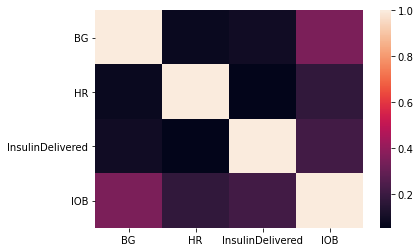

In [239]:
sns.heatmap(final_merged.corr())

count    39151.000000
mean        66.308811
std         19.709397
min         39.000000
25%         52.000000
50%         61.216667
75%         74.000000
max        182.886364
Name: HR, dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


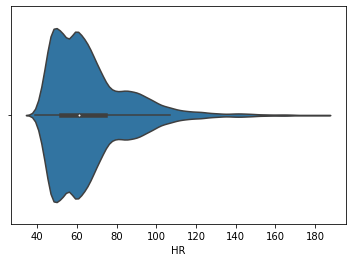

In [240]:
print(final_merged['HR'].describe())
sns.violinplot(final_merged['HR'])

count    36161.000000
mean       155.135177
std         58.557158
min         40.000000
25%        113.000000
50%        145.000000
75%        188.000000
max        402.000000
Name: BG, dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


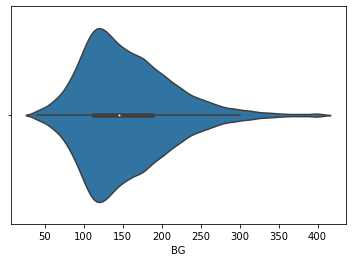

In [241]:
print(final_merged['BG'].describe())
sns.violinplot(final_merged['BG'])

count    45762.000000
mean         0.051344
std          0.389872
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.060000
Name: InsulinDelivered, dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


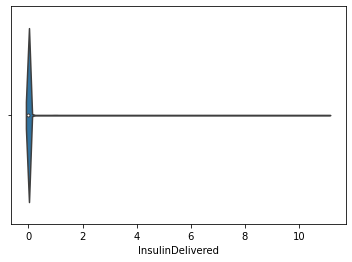

In [242]:
print(final_merged['InsulinDelivered'].describe())
sns.violinplot(final_merged['InsulinDelivered'])

# Construct Transition Model

In [309]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
final_merged = pd.read_csv(f'{BASE_PATH}/merged.csv', index_col=0)
final_merged

,Time,BG,HR,InsulinDelivered,IOB
0,2023-02-18 06:55:00,250.0,NaN,0.0,0.0
1,2023-02-18 07:00:00,242.0,NaN,0.0,0.0
2,2023-02-18 07:05:00,239.0,NaN,0.0,0.0
3,2023-02-18 07:10:00,237.0,NaN,0.0,0.0
4,2023-02-18 07:15:00,237.0,NaN,0.0,0.0
...,...,...,...,...,...
45757,2023-08-19 18:05:00,63.0,94.000,0.0,0.0
45758,2023-08-19 18:20:00,63.0,78.500,0.0,0.0
45759,2023-08-19 18:25:00,63.0,66.785,0.0,0.0
45760,2023-08-19 18:30:00,63.0,71.000,0.0,0.0


If `s` only included the past 5 minutes of blood sugar, the next state `s'` wouldn't be much different from `s` since it takes 1-2 hours for insulin to peak. Therefore, it would be best to include at least an hour of blood sugar history. We can make our transition `T(s, a, s')` model as follows:
- `s` contains the past 1.5 hour's blood sugar readings, the past 1.5 hour's HR readings, and the next 1.5 hour's IOB.
- `a` contains a bolus amount.
- `s'` contains the next 1.5 hour's blood sugar readings, the next 1.5 hour's HR readings, and the next 1.5 hour's IOB. 

In [318]:
def make_transition_model(final_merged, timesteps=2):
    for timestep in range(1, 2*timesteps):
        final_merged[f'BG_t{timestep}'] = final_merged['BG'].shift(timestep)
        final_merged[f'HR_t{timestep}'] = final_merged['HR'].shift(timestep)
        final_merged[f'IOB_t{timestep}'] = final_merged['IOB'].shift(timestep)

    final_merged[f'InsulinDelivered'] = final_merged['InsulinDelivered'].shift(timesteps-1)
    final_merged = final_merged.rename(columns={'BG': 'BG_t0', 'HR': 'HR_t0', 'IOB': 'IOB_t0'})
    col_order = [f'BG_t{t}' for t in range(timesteps)] + [f'HR_t{t}' for t in range(timesteps)] + [f'IOB_t{t}' for t in range(timesteps)] + [f'InsulinDelivered'] + [f'BG_t{t}' for t in range(timesteps, 2*timesteps)] + [f'HR_t{t}' for t in range(timesteps, 2*timesteps)] + [f'IOB_t{t}' for t in range(timesteps, 2*timesteps)]
    final_merged = final_merged[col_order]
    final_merged = final_merged.dropna(axis=0).reset_index(drop=True)
    return final_merged

In [319]:
tx_model = make_transition_model(final_merged, timesteps=18)

<ipython-input-318-e116529d3b2e>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_merged[f'HR_t{timestep}'] = final_merged['HR'].shift(timestep)
<ipython-input-318-e116529d3b2e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_merged[f'IOB_t{timestep}'] = final_merged['IOB'].shift(timestep)
<ipython-input-318-e116529d3b2e>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

In [334]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         display(tx_model[tx_model['InsulinDelivered'] > 10].T)

In [321]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
tx_model.to_csv(f'{BASE_PATH}/transition_model_90_min_history.csv')

# Determine Reward

Inspired by [this](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0274608) paper, we use a simple reward to “encourage large episodes, which results in extended periods within adequate BG level regimes.” A reward of 1 is given if BG is in range; 0 if it's in an acceptable range; and -10 if it's severly out of range (causing hypo/hyperglycemia). 

In [322]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
tx_model = pd.read_csv(f'{BASE_PATH}/transition_model_90_min_history.csv', index_col=0)

In [332]:
most_recent_bg_ind = max([int(col[4:]) for col in tx_model.columns if 'BG' in col])
target_bg_range_low = 90
target_bg_range_high = 130

def reward(bg):
    if bg > target_bg_range_low and bg < target_bg_range_high:
        return 1
    elif bg > 50 or bg < 250:
        return 0
    else: 
        return -10

tx_model['reward'] = tx_model.apply(lambda x: reward(x[f'BG_t{most_recent_bg_ind}']), axis=1)

In [333]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
tx_model.to_csv(f'{BASE_PATH}/transition_model_90_min_history_rewards.csv')